In [1]:
import numpy as np
import scipy
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

In [2]:
SPX = yf.download('^GSPC', start = '2005-01-01', interval = '1d')
CAC = yf.download('^FCHI', start = '2005-01-01', interval = '1d')
HSI = yf.download('^HSI', start = '2005-01-01', interval = '1d')
Nikkei = yf.download('^N225', start = '2005-01-01', interval = '1d')
VIX = yf.download('^VIX', start = SPX.index[1], interval = '1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
SPX

Open         High          Low        Close    Adj Close  \
Date                                                                          
2004-12-31  1213.550049  1217.329956  1211.650024  1211.920044  1211.920044   
2005-01-03  1211.920044  1217.800049  1200.319946  1202.079956  1202.079956   
2005-01-04  1202.079956  1205.839966  1185.390015  1188.050049  1188.050049   
2005-01-05  1188.050049  1192.729980  1183.719971  1183.739990  1183.739990   
2005-01-06  1183.739990  1191.630005  1183.270020  1187.890015  1187.890015   
...                 ...          ...          ...          ...          ...   
2022-10-26  3825.969971  3886.149902  3824.070068  3830.600098  3830.600098   
2022-10-27  3834.689941  3859.949951  3803.790039  3807.300049  3807.300049   
2022-10-28  3808.260010  3905.419922  3808.260010  3901.060059  3901.060059   
2022-10-31  3881.850098  3893.729980  3863.179932  3871.979980  3871.979980   
2022-11-01  3901.790039  3911.790039  3843.800049  3860.229980  3860.229980   

                Volume  log_returns  
Date                                 
2004-12-31   786900000          NaN  
2005-01-03  1510800000    -0.008153  
2005-01-04  1721000000    -0.011740  
2005-01-05  1738900000    -0.003634  
2005-01-06  1569100000     0.003500  
...                ...          ...  
2022-10-26  4817310000    -0.007415  
2022-10-27  4687320000    -0.006101  
2022-10-28  4459410000     0.024328  
2022-10-31  4820620000    -0.007482  
2022-11-01  2122077000    -0.003039  

[4491 rows x 7 columns]

In [3]:
class garchOneOne(object):
       
    def __init__(self, logReturns):
        self.logReturns = logReturns * 100
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        length = len(self.logReturns)
        sigma_2 = np.zeros(length)
        # Calculation of the formula
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        length = len(self.logReturns)
        sigma_2 = self.garch_filter(parameters) 
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        parameters = [.1, .05, .92]
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters, bounds = ((.001,1),(.001,1),(.001,1)))
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])
        return np.append(opt.x, variance)

In [4]:
SPX['log_returns'] = np.log(SPX['Adj Close']) - np.log(SPX['Adj Close'].shift(1))
CAC['log_returns'] = np.log(CAC['Adj Close']) - np.log(CAC['Adj Close'].shift(1))
HSI['log_returns'] = np.log(HSI['Adj Close']) - np.log(HSI['Adj Close'].shift(1))
Nikkei['log_returns'] = np.log(Nikkei['Adj Close']) - np.log(Nikkei['Adj Close'].shift(1))

In [5]:
# Estimation using our previously coded classes
modelSPX = garchOneOne(SPX['log_returns'][1:])
modelCAC = garchOneOne(CAC['log_returns'][1:])
modelHSI = garchOneOne(HSI['log_returns'][1:])
modelNikkei = garchOneOne(Nikkei['log_returns'][1:])

In [6]:
dfSPX = pd.DataFrame(np.sqrt(modelSPX.sigma_2*252), index = SPX.index[1:])
dfCAC = pd.DataFrame(np.sqrt(modelCAC.sigma_2*252), index = CAC.index[1:])
dfHSI = pd.DataFrame(np.sqrt(modelHSI.sigma_2*252), index = HSI.index[1:])
dfNikkei = pd.DataFrame(np.sqrt(modelNikkei.sigma_2*252), index = Nikkei.index[1:])

Text(0.5, 1.0, 'performance of GARCH(1,1) Vs VIX')

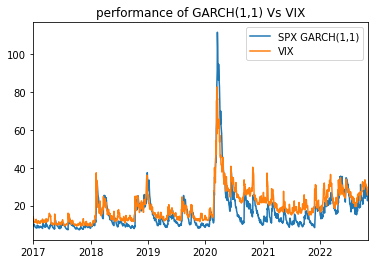

In [22]:
plt.plot(dfSPX, label = 'SPX GARCH(1,1)')
plt.plot(VIX.Close, label = 'VIX')
plt.xlim([pd.Timestamp("2017-01-01"), pd.Timestamp("2022-11-01")])
plt.legend()
plt.title('performance of GARCH(1,1) Vs VIX')

Text(0.5, 1.0, 'Evaluation of the market violate of different regions')

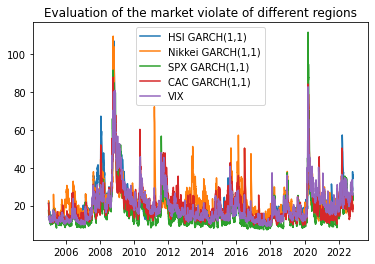

In [21]:
plt.plot(dfHSI, label = 'HSI GARCH(1,1)')
plt.plot(dfNikkei, label = 'Nikkei GARCH(1,1)')
plt.plot(dfSPX, label = 'SPX GARCH(1,1)')
plt.plot(dfCAC, label = 'CAC GARCH(1,1)')
plt.plot(VIX.Close, label = 'VIX')
plt.legend()
plt.title('Evaluation of the market violate of different regions')

Text(0.5, 1.0, 'Evaluation of the Hong Kong market violatility Vs US')

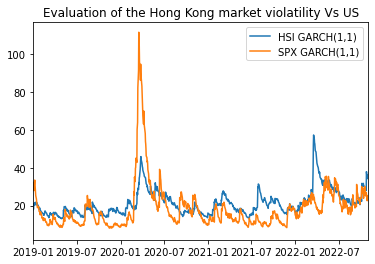

In [24]:
plt.plot(dfHSI, label = 'HSI GARCH(1,1)')
plt.plot(dfSPX, label = 'SPX GARCH(1,1)')
plt.xlim([pd.Timestamp("2019-01-01"), pd.Timestamp("2022-11-01")])
plt.legend()
plt.title('Evaluation of the Hong Kong market violatility Vs US')